In [51]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
from sklearn import preprocessing
from patsy import dmatrices
from sklearn.preprocessing import StandardScaler



sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet, LassoCV, Lasso

import patsy


In [53]:
all_cities = pd.read_csv('/Users/jyots/Desktop/DS_Projects/airbnb_DataSets/all_cities.csv',
                   encoding='utf8')

In [54]:
df = all_cities[[col for col in all_cities.columns if col not in ['bhk','neighborhood']]]

In [55]:
df.head(2)

,Unnamed: 0,bathrooms,bedrooms,dist_arprt,host_count,metrostn_count,minstay,overall_satisfaction,price,rest_count,reviews,review_count,room_type,city
0,0,1.0,1.0,0.266061,565,6,2.0,5.0,113.0,10,8,7423,Entire home/apt,paris
1,1,1.0,1.0,0.089208,2340,3,7.0,2.0,79.0,1,2,28620,Entire home/apt,copenhagen


In [56]:
df.drop('Unnamed: 0', axis=1, inplace=True)

/Users/Jyots/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [57]:
def balanced_stratified_sample(df, col="recommended"):
   
   group_df = df.groupby(col)
   
   minimum_sample_size = group_df.size().min()
   
   new_data = pd.DataFrame()
   
   for group_name, g_df in group_df:
        sample = g_df.sample(minimum_sample_size)
        new_data = pd.concat([new_data, sample])
   
   return pd.DataFrame(new_data)
       
stratified_df = balanced_stratified_sample(df, col="city")   
print "stratified sample: ", stratified_df.groupby("city").size()
print "original sample:", df.groupby("city").size()

stratified sample:  city
barcelona     13875
berlin        13875
copenhagen    13875
paris         13875
rome          13875
dtype: int64
original sample: city
barcelona     13875
berlin        14790
copenhagen    14541
paris         41124
rome          15585
dtype: int64


In [58]:
# stratified_df.drop('Unnamed: 0', axis=1, inplace=True)
stratified_df = stratified_df.reset_index(drop=True)
X = stratified_df[[x for x in stratified_df.columns if x not in ['bhk','price','neighborhood']]]
    
target_classes = stratified_df['city'].unique().tolist()
stratified_df.city = stratified_df.city.map(lambda value: target_classes.index(value))
formula = "price ~ "+' + '.join(X)+' -1'
y, X = patsy.dmatrices(formula, data=stratified_df, return_type='dataframe')
y = y.values.ravel()
y = np.log(y)




In [59]:
# split train if you want
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import StratifiedKFold

Xn = StandardScaler().fit_transform(X)

#Xc = X - np.mean(X)

Xn_train, Xn_test, y_train, y_test = train_test_split(Xn, y, test_size = 0.33, random_state=42)

#Xc_train, Xc_test, y_train, y_test = train_test_split(Xc, y, test_size=0.33, random_state=42)




In [60]:
enet_cv = ElasticNetCV(l1_ratio=np.linspace(0.01, 1., 50), n_alphas=300, cv=10, verbose=1)
enet_cv.fit(Xn_train, y_train)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=array([ 0.01   ,  0.0302 ,  0.05041,  0.07061,  0.09082,  0.11102,
        0.13122,  0.15143,  0.17163,  0.19184,  0.21204,  0.23224,
        0.25245,  0.27265,  0.29286,  0.31306,  0.33327,  0.35347,
        0.37367,  0.39388,  0.41408,  0.43429,  0.45449,  0.47469,
        0.4949 ,  0.515...3837,
        0.85857,  0.87878,  0.89898,  0.91918,  0.93939,  0.95959,
        0.9798 ,  1.     ]),
       max_iter=1000, n_alphas=300, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=1)

In [61]:
print enet_cv.l1_ratio_
print enet_cv.alpha_

1.0
0.000347742230472


In [62]:
enet = ElasticNet(alpha= enet_cv.alpha_, l1_ratio=enet_cv.l1_ratio_)

y_pred_enet = enet.fit(Xn_train, y_train).predict(Xn_test)
r2_score_enet = metrics.r2_score(y_test, y_pred_enet)
print(enet)
print("r^2 on test data : %f" % r2_score_enet)


ElasticNet(alpha=0.00034774223047236846, copy_X=True, fit_intercept=True,
      l1_ratio=1.0, max_iter=1000, normalize=False, positive=False,
      precompute=False, random_state=None, selection='cyclic', tol=0.0001,
      warm_start=False)
r^2 on test data : 0.535085


In [63]:
residuals = np.exp(y_test) - np.exp(y_pred_enet)

In [84]:
rr = [x for x in residuals.tolist() if x<0]
len(rr)

11930

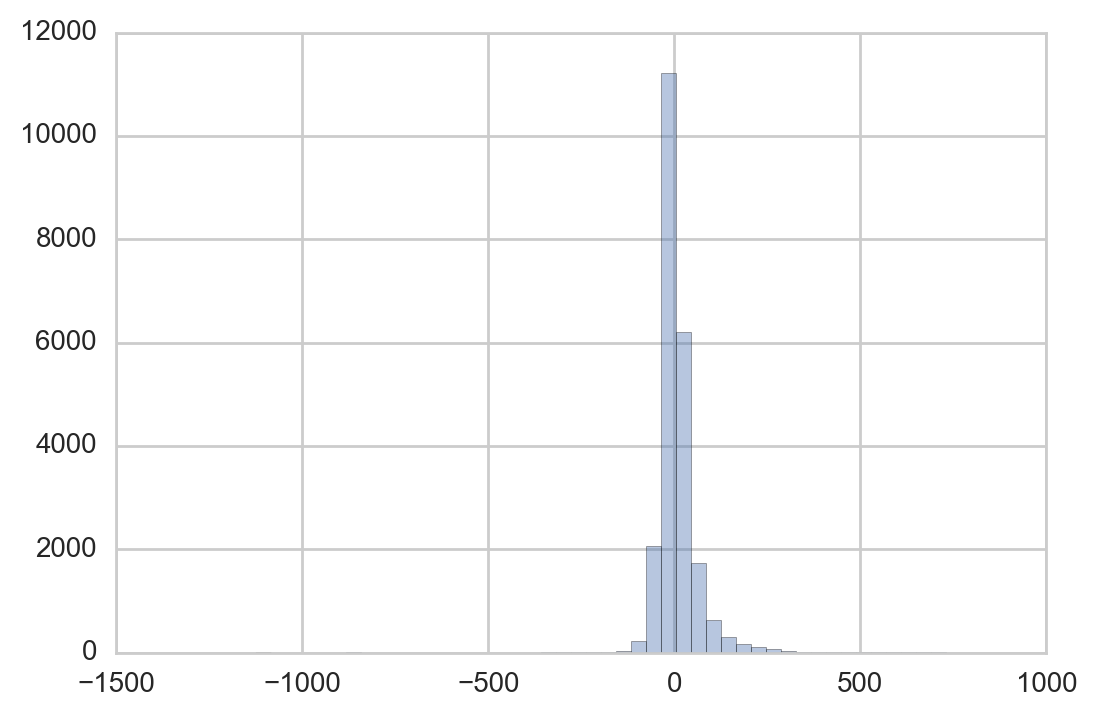

In [64]:
sns.distplot(residuals, bins=50, kde=False)


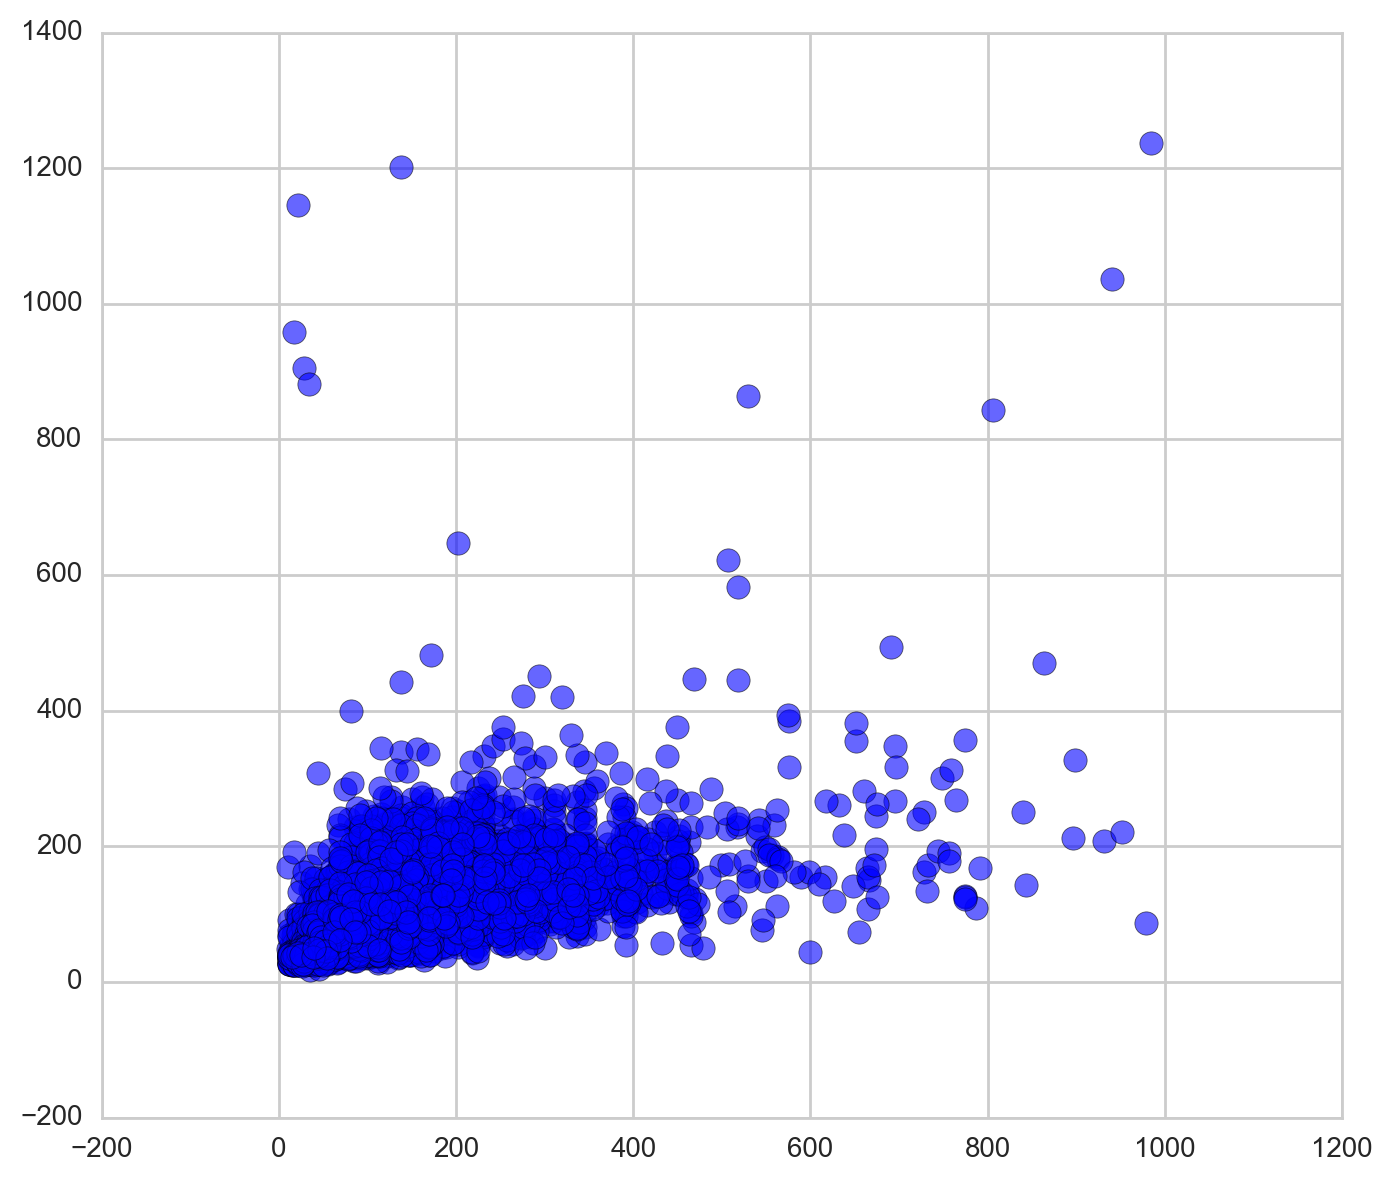

In [65]:
fig, ax = plt.subplots(figsize=(8,7))
ax.scatter(np.exp(y_test), np.exp(y_pred_enet), s=70, alpha=0.6)
plt.show()

In [66]:
enet.fit(Xn_train, y_train)

enet_coef = pd.DataFrame({
        'variable':X.columns,
        'coef':enet.coef_,
        'abscoef':np.abs(enet.coef_)
    })

enet_coef.sort_values('abscoef', ascending=False, inplace=True)
enet_coef[enet_coef.coef != 0].head(25)


,abscoef,coef,variable
0,0.264255,0.264255,room_type[Entire home/apt]
4,0.188415,0.188415,bedrooms
13,0.167929,0.167929,city
12,0.128863,0.128863,review_count
7,0.084395,-0.084395,metrostn_count
5,0.065945,-0.065945,dist_arprt
3,0.051437,0.051437,bathrooms
2,0.033093,-0.033093,room_type[Shared room]
8,0.030501,-0.030501,minstay
6,0.029331,-0.029331,host_count


In [67]:
enet_coef = enet_coef.reset_index(drop=True)


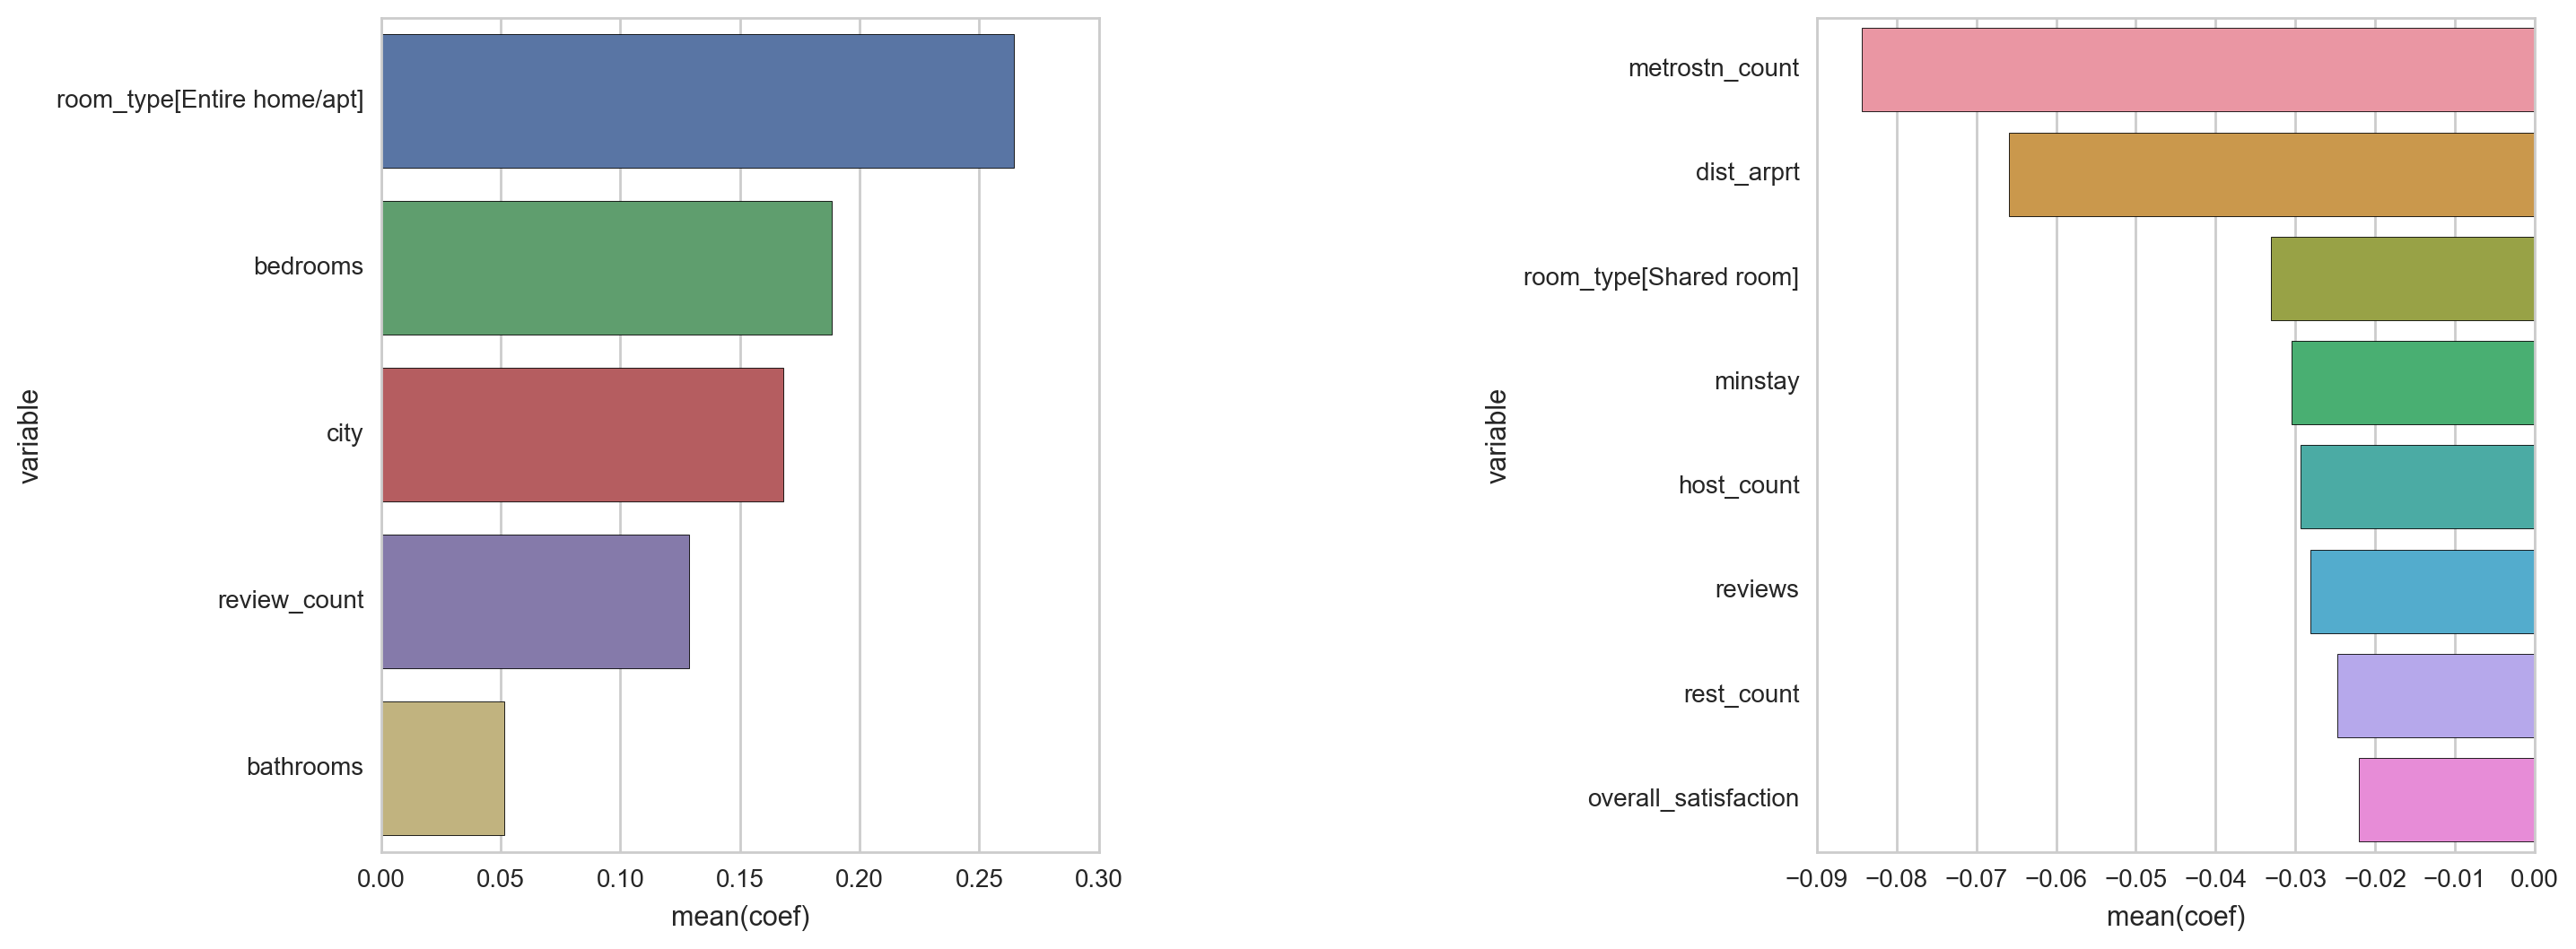

In [79]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,6))
plt.subplots_adjust(left= -1, bottom=None, right=0.5, top=None,
                  wspace=1, hspace=0.4)


sns.barplot(y = enet_coef[enet_coef.coef > 0].variable, x = enet_coef[enet_coef.coef > 0].coef, data=enet_coef,
            ax=ax1
           )

sns.barplot(y = enet_coef[enet_coef.coef < 0].variable, x = enet_coef[enet_coef.coef < 0].coef, data=enet_coef,
            ax=ax2,
           )
plt.show()